In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


/kaggle/input/plate-zindi/SampleSubmission.csv
/kaggle/input/plate-zindi/license_plates_recognition_train.csv
/kaggle/input/plate-zindi/license_plates_detection_train.csv
/kaggle/input/plate-zindi/test/test_private/968.jpg
/kaggle/input/plate-zindi/test/test_private/1024.jpg
/kaggle/input/plate-zindi/test/test_private/930.jpg
/kaggle/input/plate-zindi/test/test_private/947.jpg
/kaggle/input/plate-zindi/test/test_private/1017.jpg
/kaggle/input/plate-zindi/test/test_private/1111.jpg
/kaggle/input/plate-zindi/test/test_private/1063.jpg
/kaggle/input/plate-zindi/test/test_private/1036.jpg
/kaggle/input/plate-zindi/test/test_private/1079.jpg
/kaggle/input/plate-zindi/test/test_private/920.jpg
/kaggle/input/plate-zindi/test/test_private/979.jpg
/kaggle/input/plate-zindi/test/test_private/937.jpg
/kaggle/input/plate-zindi/test/test_private/1060.jpg
/kaggle/input/plate-zindi/test/test_private/1087.jpg
/kaggle/input/plate-zindi/test/test_private/925.jpg
/kaggle/input/plate-zindi/test/test_priva

/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/907.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/810.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/614.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/173.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/356.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/300.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/720.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/673.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/480.jpg
/kaggle/input/plate-zindi/license_plates_recognition_train/license_plates_recognition_train/274.jpg


In [2]:
df = pd.read_csv('/kaggle/input/plate-zindi/license_plates_detection_train.csv')

In [3]:
IMAGES_TRAINING = "/kaggle/input/plate-zindi/license_plates_detection_train/license_plates_detection_train/"

In [4]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["ymin"] = list()
dataset["xmin"] = list()
dataset["ymax"] = list()
dataset["xmax"] = list()   

for index, row in df.iterrows():
    img = Image.open(IMAGES_TRAINING+row['img_id'])
    dataset["image_name"].append(row['img_id'])
    width, height = img.size 
    dataset["image_width"].append(width)
    dataset["image_height"].append(height)
    dataset["ymin"].append(row['ymin'])
    dataset["xmin"].append(row['xmin'])
    dataset["ymax"].append(row['ymax'])
    dataset["xmax"].append(row['xmax'])



In [5]:
df = pd.DataFrame(dataset)
df.drop(["image_width", "image_height"], axis=1, inplace=True)
ll = df.values.tolist()
for item in ll:
    del item[0]
df['combined']= ll
df

,image_name,ymin,xmin,ymax,xmax,combined
0,1.jpg,276,94,326,169,"[276, 94, 326, 169]"
1,10.jpg,311,395,344,444,"[311, 395, 344, 444]"
2,100.jpg,406,263,450,434,"[406, 263, 450, 434]"
3,101.jpg,283,363,315,494,"[283, 363, 315, 494]"
4,102.jpg,139,42,280,222,"[139, 42, 280, 222]"
...,...,...,...,...,...,...
895,95.jpg,426,34,508,140,"[426, 34, 508, 140]"
896,96.jpg,356,378,457,548,"[356, 378, 457, 548]"
897,97.jpg,229,149,283,217,"[229, 149, 283, 217]"
898,98.jpg,272,252,300,383,"[272, 252, 300, 383]"


In [6]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [7]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread(IMAGES_TRAINING + df["image_name"].iloc[index])
    width, height = image.shape[0], image.shape[1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    x_scale = ( WIDTH / height)
    y_scale = ( HEIGHT / width )
    tx = int(df["xmin"].iloc[index] * x_scale)
    ty = int(df["ymin"].iloc[index]* y_scale)
    bx = int(df["xmax"].iloc[index]* x_scale)
    by = int(df["ymax"].iloc[index]* y_scale)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

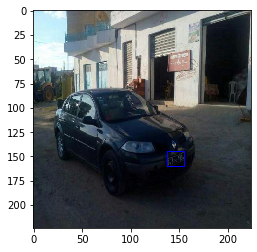

In [8]:
show_img(1)

In [15]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=IMAGES_TRAINING,
    x_col="image_name",
    y_col=["combined"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="multi_output",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=IMAGES_TRAINING,
    x_col="image_name",
    y_col=["combined"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="multi_output",
    subset="validation")

Found 806 validated image filenames.
Found 89 validated image filenames.


In [16]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
__________________________________

In [17]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 26
Validation step size: 3


In [18]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [19]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Epoch 1/30


ValueError: Output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: [[[[0.24313727 0.19607845 0.14117648]
   [0.26666668 0.23137257 0.17254902]
   [0.2901961  0.26666668 0.20392159]
   ...
   [0.6784314  0.6313726  0.58431375]
   [0.63529414 0.5803922  0.5372549 ]
   [0.65882355 0.6156863  0.54509807]]

  [[0.2627451  0.20000002 0.13725491]
   [0.29411766 0.24313727 0.1764706 ]
   [0.2784314  0.24705884 0.17254902]
   ...
   [0.67058825 0.6039216  0.5411765 ]
   [0.6862745  0.61960787 0.5568628 ]
   [0.65882355 0.59607846 0.49803925]]

  [[0.25882354 0.19215688 0.1137255 ]
   [0.2901961  0.23137257 0.14901961]
   [0.32156864 0.2784314  0.19215688]
   ...
   [0.59607846 0.5137255  0.43137258]
   [0.7568628  0.6745098  0.5921569 ]
   [0.70980394 0.6313726  0.53333336]]

  ...

  [[0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   ...
   [0.6156863  0.5686275  0.5764706 ]
   [0.6156863  0.5686275  0.5764706 ]
   [0.6117647  0.57254905 0.5764706 ]]

  [[0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   ...
   [0.6313726  0.58431375 0.58431375]
   [0.62352943 0.5764706  0.5764706 ]
   [0.6156863  0.5686275  0.5686275 ]]

  [[0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   [0.2627451  0.16078432 0.10196079]
   ...
   [0.6313726  0.58431375 0.58431375]
   [0.61960787 0.57254905 0.57254905]
   [0.6392157  0.5921569  0.5921569 ]]]


 [[[0.65882355 0.65882355 0.65882355]
   [0.6745098  0.6745098  0.6745098 ]
   [0.6784314  0.68235296 0.6627451 ]
   ...
   [0.9960785  0.9960785  0.9960785 ]
   [0.94117653 0.9490197  0.9450981 ]
   [0.90196085 0.909804   0.9058824 ]]

  [[0.6784314  0.6784314  0.6784314 ]
   [0.64705884 0.64705884 0.64705884]
   [0.6627451  0.6666667  0.64705884]
   ...
   [0.9686275  0.9686275  0.9686275 ]
   [0.9490197  0.9568628  0.95294124]
   [0.9725491  0.9803922  0.97647065]]

  [[0.6862745  0.6862745  0.6862745 ]
   [0.7137255  0.7137255  0.7137255 ]
   [0.67058825 0.6745098  0.654902  ]
   ...
   [0.9803922  0.9803922  0.9803922 ]
   [0.98823535 0.9960785  0.9921569 ]
   [0.9607844  0.9686275  0.96470594]]

  ...

  [[0.5137255  0.52156866 0.5176471 ]
   [0.5176471  0.5176471  0.5176471 ]
   [0.4784314  0.4784314  0.47058827]
   ...
   [0.47450984 0.47450984 0.4666667 ]
   [0.44705886 0.45098042 0.427451  ]
   [0.43529415 0.43921572 0.41960788]]

  [[0.49803925 0.5058824  0.5019608 ]
   [0.49411768 0.49411768 0.49411768]
   [0.48235297 0.48235297 0.47450984]
   ...
   [0.5019608  0.5019608  0.49411768]
   [0.4784314  0.48235297 0.45882356]
   [0.47058827 0.47450984 0.454902  ]]

  [[0.49803925 0.5058824  0.5019608 ]
   [0.43529415 0.43529415 0.43529415]
   [0.454902   0.454902   0.44705886]
   ...
   [0.50980395 0.50980395 0.5019608 ]
   [0.48627454 0.4901961  0.4666667 ]
   [0.47058827 0.47450984 0.454902  ]]]


 [[[0.9843138  0.9921569  0.98823535]
   [0.9843138  0.9921569  0.98823535]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9843138  0.9921569  0.98823535]]

  [[0.9843138  0.9921569  0.98823535]
   [0.9843138  0.9921569  0.98823535]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]]

  [[0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.97647065 0.9921569  0.9960785 ]
   [0.97647065 0.9921569  0.9960785 ]
   [0.9725491  0.98823535 0.9843138 ]]

  ...

  [[0.32941177 0.3254902  0.34901962]
   [0.37647063 0.37254903 0.39607847]
   [0.3254902  0.32156864 0.34509805]
   ...
   [0.20392159 0.20392159 0.20392159]
   [0.23529413 0.23529413 0.23529413]
   [0.19607845 0.19607845 0.19607845]]

  [[0.3529412  0.34117648 0.36862746]
   [0.34901962 0.3372549  0.3647059 ]
   [0.3254902  0.3137255  0.34117648]
   ...
   [0.20784315 0.20784315 0.20784315]
   [0.19607845 0.19607845 0.19607845]
   [0.20392159 0.20392159 0.20392159]]

  [[0.36078432 0.34901962 0.37647063]
   [0.36862746 0.35686275 0.38431376]
   [0.32156864 0.30980393 0.3372549 ]
   ...
   [0.20000002 0.20000002 0.20000002]
   [0.1764706  0.1764706  0.1764706 ]
   [0.21176472 0.21176472 0.21176472]]]


 ...


 [[[0.87843144 0.9215687  0.9450981 ]
   [0.8862746  0.92549026 0.9607844 ]
   [0.8745099  0.91372555 0.9607844 ]
   ...
   [0.69803923 0.7254902  0.76470596]
   [0.7058824  0.73333335 0.76470596]
   [0.69411767 0.7137255  0.7372549 ]]

  [[0.87843144 0.9215687  0.9450981 ]
   [0.8862746  0.92549026 0.9607844 ]
   [0.8745099  0.91372555 0.9607844 ]
   ...
   [0.6901961  0.7176471  0.7568628 ]
   [0.7019608  0.7294118  0.7607844 ]
   [0.6862745  0.7058824  0.7294118 ]]

  [[0.87843144 0.9215687  0.9450981 ]
   [0.8862746  0.92549026 0.9607844 ]
   [0.8745099  0.91372555 0.9607844 ]
   ...
   [0.6862745  0.7137255  0.75294125]
   [0.69803923 0.7254902  0.7568628 ]
   [0.68235296 0.7019608  0.7254902 ]]

  ...

  [[0.854902   0.854902   0.854902  ]
   [0.8431373  0.8431373  0.8352942 ]
   [0.854902   0.8588236  0.83921576]
   ...
   [0.6509804  0.6509804  0.65882355]
   [0.6901961  0.6901961  0.6901961 ]
   [0.654902   0.654902   0.654902  ]]

  [[0.86274517 0.86274517 0.86274517]
   [0.83921576 0.83921576 0.8313726 ]
   [0.8588236  0.86274517 0.8431373 ]
   ...
   [0.6901961  0.6901961  0.69803923]
   [0.70980394 0.70980394 0.70980394]
   [0.7058824  0.7058824  0.7058824 ]]

  [[0.86274517 0.86274517 0.8705883 ]
   [0.8862746  0.8862746  0.8862746 ]
   [0.8431373  0.83921576 0.8235295 ]
   ...
   [0.65882355 0.654902   0.6745098 ]
   [0.6901961  0.6862745  0.7058824 ]
   [0.7019608  0.69803923 0.7176471 ]]]


 [[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   [1.         1.         0.9921569 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.98823535 0.9843138  1.        ]
   [0.73333335 0.7294118  0.7490196 ]
   [0.9921569  0.9921569  1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.9725491  0.9686275  1.        ]
   [0.62352943 0.61960787 0.6509804 ]
   [0.7137255  0.70980394 0.7411765 ]]

  ...

  [[0.18431373 0.18823531 0.05490196]
   [0.28235295 0.27058825 0.14901961]
   [0.26666668 0.227451   0.12156864]
   ...
   [0.23137257 0.15294118 0.15686275]
   [0.30980393 0.2392157  0.23137257]
   [0.2509804  0.19215688 0.18039216]]

  [[0.16470589 0.15686275 0.07450981]
   [0.29803923 0.27058825 0.20000002]
   [0.18039216 0.1254902  0.07450981]
   ...
   [0.28627452 0.20784315 0.21176472]
   [0.2509804  0.18039216 0.17254902]
   [0.21960786 0.16078432 0.14901961]]

  [[0.37254903 0.34901962 0.3019608 ]
   [0.29803923 0.25882354 0.22352943]
   [0.227451   0.16862746 0.14117648]
   ...
   [0.24705884 0.16862746 0.17254902]
   [0.22352943 0.15294118 0.14509805]
   [0.18039216 0.12156864 0.10980393]]]


 [[[0.9843138  0.9921569  0.98823535]
   [0.9843138  0.9921569  0.98823535]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9843138  0.9921569  0.98823535]]

  [[0.9843138  0.9921569  0.98823535]
   [0.9843138  0.9921569  0.98823535]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]]

  [[0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   [0.9803922  0.98823535 0.9843138 ]
   ...
   [0.97647065 0.9921569  0.9960785 ]
   [0.97647065 0.9921569  0.9960785 ]
   [0.9725491  0.98823535 0.9843138 ]]

  ...

  [[0.32941177 0.3254902  0.34901962]
   [0.37647063 0.37254903 0.39607847]
   [0.3254902  0.32156864 0.34509805]
   ...
   [0.20392159 0.20392159 0.20392159]
   [0.23529413 0.23529413 0.23529413]
   [0.19607845 0.19607845 0.19607845]]

  [[0.3529412  0.34117648 0.36862746]
   [0.34901962 0.3372549  0.3647059 ]
   [0.3254902  0.3137255  0.34117648]
   ...
   [0.20784315 0.20784315 0.20784315]
   [0.19607845 0.19607845 0.19607845]
   [0.20392159 0.20392159 0.20392159]]

  [[0.36078432 0.34901962 0.37647063]
   [0.36862746 0.35686275 0.38431376]
   [0.32156864 0.30980393 0.3372549 ]
   ...
   [0.20000002 0.20000002 0.20000002]
   [0.1764706  0.1764706  0.1764706 ]
   [0.21176472 0.21176472 0.21176472]]]]

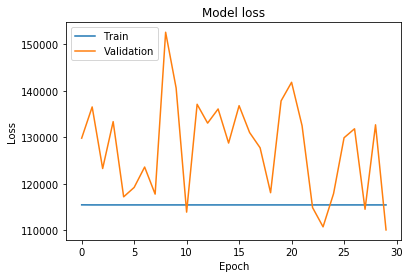

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()